<h1 style="text-align: center;"><b>Heston model</b></h1>

### Maksim Sosnin, Roland Grinis, Dmitry Bazanov, Ivan Novikov

Heston model is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1. $$

# Heston calibration

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1},
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

For semi-analytical gradient formulae w.r.t. to all model parameters see Cui et al. (2016)

Heston surfaces is free of any *static arbitrage*. 

#### Delta computation
See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

# Heston simulation

$$d \ln X(t) = -\frac{1}{2} V(t) dt + \sqrt{V(t)} d W_X(t),$$

$$d V(t) = \kappa(\theta-V(t)) dt + \varepsilon \sqrt{V(t)} d W_V(t),$$

$$d W_X(t) d W_V(t) = \rho dt.$$

We can impose the Feller condition:

$$2\kappa\theta > \varepsilon^2$$

to ensure that the variance $V_t$ stays strictly positive. For real markets, Feller condition is hardly satisfied. For continious time, this is not an issue, because at the moment the variance reaches 0, it will instantly go away from 0. For discretization is requires special consideration for different schemes.

### Euler Discretization Scheme

$$
\begin{aligned}
\ln \hat{X}(t+\Delta) & =\ln \hat{X}(t)-\frac{1}{2} \hat{V}(t) \Delta+\sqrt{\hat{V}(t)} Z_X \sqrt{\Delta}, \\
\hat{V}(t+\Delta) & =V(t)+\kappa(\theta-\hat{V}(t)) \Delta+\varepsilon \sqrt{\hat{V}(t)} Z_V \sqrt{\Delta},
\end{aligned}
$$

where $Z_X$ and $Z_V$ are standardized Gaussian variables with correlation $\rho$. So they can be computed as follows:

$$
\begin{array}{l}
    Z_V = \Phi^{-1}\left(U_1\right), \\
    Z_X = \rho Z_V+\sqrt{1-\rho^2} \Phi^{-1}\left(U_2\right),
\end{array}
$$

where $U_1$ and $U_2$ are independent uniform samples, and $Φ^{−1}$ is the inverse cumulative Gaussian distribution function.

However, the discrete process for $V$ can become negative with non-zero probability, which in turn would make computation of $\sqrt{\hat{V}}$ impossible and cause the time-stepping scheme to fail. The scheme that appears to produce the smallest discretization bias can be written on the form:

$$
\begin{aligned}
\ln \hat{X}(t+\Delta) & =\ln \hat{X}(t)-\frac{1}{2} \hat{V}(t)^{+} \Delta+\sqrt{\hat{V}(t)^{+}} Z_X \sqrt{\Delta} \\
\hat{V}(t+\Delta) & =\hat{V}(t)+\kappa\left(\theta-\hat{V}(t)^{+}\right) \Delta+\varepsilon \sqrt{\hat{V}(t)^{+}} Z_V \sqrt{\Delta},
\end{aligned}
$$
where we use the notation $x^{+}=\max (x, 0)$.

### Bias free Scheme

To obtain a bias-free scheme for sampling the asset price process, first integrate the SDE for $V(t)$, to yield
$$
V(t+\Delta)=V(t)+\int_t^{t+\Delta} \kappa(\theta-V(u)) d u+\varepsilon \int_t^{t+\Delta} \sqrt{V(u)} d W_V(u)
$$
or, equivalently,
$$
\int_t^{t+\Delta} \sqrt{V(u)} d W_V(u)=\varepsilon^{-1}\left(V(t+\Delta)-V(t)-\kappa \theta \Delta+\kappa \int_t^{t+\Delta} V(u) d u\right)
$$
A Cholesky decomposition shows that
$$
d \ln X(t)=-\frac{1}{2} V(t) d t+\rho \sqrt{V(t)} d W_V(t)+\sqrt{1-\rho^2} \sqrt{V(t)} d W(t)
$$
where $W$ is a Brownian motion independent of $W_V$. In integral form,
$$
\begin{aligned}
\ln X(t+\Delta)=\ln X(t)+\frac{\rho}{\varepsilon} & (V(t+\Delta)-V(t)-\kappa \theta \Delta) \\
& +\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right) \int_t^{t+\Delta} V(u) d u+\sqrt{1-\rho^2} \int_t^{t+\Delta} \sqrt{V(u)} d W(u)
\end{aligned}
$$

As $W$ is independent of $V$, conditional on $V(t)$ and $\int_t^{t+\Delta} V(u) d u$, the Ito integral $\int_t^{t+\Delta} \sqrt{V(u)} d W(u)$ is Gaussian with mean zero and variance $\int_t^{t+\Delta} V(u) d u$.

### Process for $V$ (CIR)

Non-central chi-squared distribution:
$$
\mathbb{P}\left(V_{t + \Delta}<V \mid V_{t}\right) \quad = \quad F_{\chi'^{2}}\left(\frac{4 \kappa V}{\varepsilon^{2}\left(1-e^{-\kappa \Delta}\right)} ; \frac{4 \kappa \theta}{\varepsilon^{2}}, \frac{4 V_{t} \kappa e^{-\kappa \Delta}}{\varepsilon^{2}\left(1-e^{-\kappa \Delta}\right)}\right) \quad
$$


$$
\begin{aligned}
m = \mathbb{E}\left( V_{t+\Delta} \mid V_t \right) \quad & = \quad \theta+(\hat{V}(t)-\theta) e^{-\kappa \Delta} \\
s^2 = Var\left( V_{t+\Delta} \mid V_t \right) \quad & = \quad \frac{\hat{V}(t) \varepsilon^2 e^{-\kappa \Delta}}{\kappa}\left(1-e^{-\kappa \Delta}\right)+\frac{\theta \varepsilon^2}{2 \kappa}\left(1-e^{-\kappa \Delta}\right)^2
\end{aligned}
$$


### Quadratic exponential (QE) approximation

Switching rule:
- $ V_t \gg 1: \quad V_{t+\Delta} \approx a \left( b + Z_V \right)^2,\quad \text{where } Z_V \sim \mathcal{N}(0,1).$
- $V_t \ll 1: \quad f_{V_{t+\Delta}}(v) \approx p \delta(v) + \beta(1-\rho) e^{-\beta v}.$

Fast sampling for PDF $f_{V_{t+\Delta}}(v)$:
$$
\begin{aligned}
F_{V_{t+\Delta}}^{-1}(u) & \approx\left\{
    \begin{array}{l}
        0,\ \ 0 \leq u \leq p, \\
        \beta^{-1} \ln \left(\frac{1-p}{1-u}\right),\ \ p \leq u \leq 1,
    \end{array}\right. \\
\end{aligned}
$$
where $u \sim \mathcal{U}[0,1]$ – uniform.

### Generating random numbers

Pseudo-random integers:
$$
0 \leq N_k \leq N, \quad \quad N_{k+1} = f(N_k) \equiv N
$$

$$
u \sim \mathcal{U}[0,1], \quad \quad u_k = \frac{N_k}{N}.
$$

Box-Muller method:
$$ u_1 u_2 \sim \mathcal{U}[0,1] \quad \theta = 2\pi u_2 \quad p = \sqrt{-2 \ln{u_1}} $$

$$ Z_1 = p\cos{\theta} $$
$$ Z_2 = p\sin{\theta} $$
Then $Z_1$ and $Z_2$ are independent random variables with a standard normal distribution $\mathcal{N}(0,1).$


### Computing parameters $(a,\ b,\ p,\ \beta)$

$\psi \equiv \frac{s^{2}}{m^{2}} \quad \text { if } \psi \leqslant 2$:
$$
\begin{array}{l}
b^{2}=2 \psi^{-1}-1+\sqrt{2 \psi^{-1}} \sqrt{2 \psi^{-1}-1} \geq 0 \\
a=\frac{m}{1+b^{2}} \\
\implies \text {moment matching at order 2.}
\end{array}
$$

if $\psi \geqslant 1$:
$$
\begin{array}{l}
p=\frac{\psi-1}{\psi+2} \in[0,1) \\
\beta=\frac{1-p}{m}=\frac{2}{m(1+\psi)} \\
\implies \text {moment matching at order 2.}
\end{array}
$$

Switching rule: $\psi_{c} \in [1,2]$, e.g. $\psi = 1.5$.

### Moment matching technique

$$
\begin{array}{l}
Y_{t_{j+1}}^{k}=\hat{V}_{t_{j+1}}^{k}-\hat{V}_{t_{j}}^{k}, \quad \Delta_{j}=t_{j+1}-t_{j}, \quad \hat{V}_{t_{N}}^{k}=\sum_{j=1}^{N} \hat{Y}_{t_{j}}^{k} \\
\Delta=t_{N}-t_{0} ; \quad k=1, \ldots, M \\
\hat{m}_{T}=\frac{1}{M} \sum_{k} \hat{V}_{t_{N}}^{k} \\
\hat{S}_{T}^{2}=\frac{1}{M-1} \sum_{k}\left(\hat{V}_{t_{N}}^{k}-\hat{m}\right)^{2}
\end{array}
$$

$$
\begin{array}{l}
\hat{m}_{T} = M_T \quad \quad m_T = \mathbb{E}[V_T \mid V_{t_0}] \\
\hat{S}^{2}_T = S^{2}_T \quad \quad S^{2}_T = Var[V_T \mid V_{t_0}] \\
\implies V^{k}_T = m_T + \frac{S_T}{\hat{S}_T} (\hat{V}^{k}_T - \hat{m}_T) = \sum_{j=1}^{N} \left(\frac{m_T}{N} + \frac{S_T}{\hat{S}_T} \left(\hat{Y}^{k}_{t_j} - \frac{m_T}{N}\right)\right).
\end{array}
$$


### Simulating $\ln{X_{t+\Delta}}$

Euler Scheme for $\ln{X_{t+\Delta}}$ with QE sampling for $V_{t+\Delta}$ leads to **correlation leaks**.

We use approximation
$$
\begin{array}{l}
 \int_{t}^{t+\Delta} V_{u} d u \approx \Delta \left[\gamma_{1}V_{t} + \gamma_{2}V_{t+\Delta}\right],
\end{array}
$$
where

$$
\begin{array}{l}
    \gamma_{1} + \gamma_{2} = 1 \\
    \gamma_{1}, \gamma_{2} \geq 0,
\end{array}
$$

satisfying the regularity condition:
$$
\mathbb{E}\left(X_{t + \Delta} \mid X_{t}\right)<\infty \Longrightarrow \frac{\rho}{\varepsilon}\left(1+\kappa \gamma_{2} \Delta\right)-\frac{1}{2} \gamma_{2} \Delta \rho^{2}<\frac{2 \kappa}{\varepsilon^{2} (1-e^{-\kappa \Delta})}.
$$

We use discretization scheme
$$
\begin{aligned}
\ln \hat{X}(t+\Delta)= & \ln \hat{X}(t) + \frac{\rho}{\varepsilon} \left( \hat{V}(t+\Delta) - \hat{V}(t)-\kappa \theta \Delta \right)+\Delta\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right)\left(\gamma_1 \hat{V}(t)+\gamma_2 \hat{V}(t+\Delta)\right) \\
& +\sqrt{\Delta} \sqrt{1-\rho^2} \sqrt{\gamma_1 \hat{V}(t)+\gamma_2 \hat{V}(t+\Delta)} \cdot Z \\
= & \ln \hat{X}(t)+K_0+K_1 \hat{V}(t)+K_2 \hat{V}(t+\Delta)+\sqrt{K_3 \hat{V}(t)+K_4 \hat{V}(t+\Delta)} \cdot Z,
\end{aligned}
$$
where $Z$ is a standard Gaussian random variable, independent of $\hat{V}$, and $K_0, \ldots, K_4$ are given by
$$
\begin{aligned}
& K_0=-\frac{\rho \kappa \theta}{\varepsilon} \Delta, \quad K_1=\gamma_1 \Delta\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right)-\frac{\rho}{\varepsilon}, \\
& K_2=\gamma_2 \Delta\left(\frac{\kappa \rho}{\varepsilon}-\frac{1}{2}\right)+\frac{\rho}{\varepsilon}, \quad K_3=\gamma_1 \Delta\left(1-\rho^2\right), \quad K_4=\gamma_2 \Delta\left(1-\rho^2\right) .
\end{aligned}
$$


### Enforcing Martingale property $\mathbb{E}\left(X_{t+\Delta} \mid X_{t}\right)=X_{t} $
Instead of $K_0$, use

$$
\begin{array}{l}
K_{0}^{*} = \left\{
    \begin{array}{l}
        -\frac{A b^{2} a}{1-2 A a}+\frac{1}{2} \ln (1-2 A a)-\left(K_{1}+\frac{1}{2} \Delta \gamma_1\right), \quad \psi \leq \psi_{c} \\
        -\ln \left(\frac{\beta(1-\rho)}{\beta-A}\right)-\left(K_{1}+\frac{1}{2} \Delta \gamma_{1}\right), \quad \psi > \psi_{c}, \\
    \end{array}\right.
\end{array}
$$

where

$$
A=\frac{\rho}{\varepsilon^{2}}\left(1+\kappa \gamma_{2} \Delta\right)-\frac{1}{2} \gamma_{2} \Delta\rho^{2}.
$$

### Variance reduction: antithetic variates

$$
\begin{array}{l}
u \sim \mathcal{U}(0,1) \longrightarrow 1-u \sim \mathcal{U}(0,1) \longrightarrow \hat{V}=\mathbb{E}\left[P\left(V_{T}\right)\right] \\
Z \sim \mathcal{N}(0,1) \longrightarrow-Z \sim \mathcal{N}(0,1) \longrightarrow V^{-} \\
V_{A V}=\frac{1}{2}\left(\hat{V}+V^{-}\right) \\
\operatorname{Var}\left[V_{A V}\right]=\frac{1}{4} \operatorname{Var}\left[\hat{V}+V^{-}\right]=\frac{1}{4} \operatorname{Var} \hat{V}+\frac{1}{4} \operatorname{Var} V^{-}+\frac{1}{2} \operatorname{Cov}\left(\hat{V}, V^{-}\right) \\
\left|\operatorname{cov}\left(\hat{V}, V^{-}\right)\right| \leqslant \frac{1}{2} \operatorname{Var} \hat{V}+\frac{1}{2} \operatorname{Var} V^{-} \Rightarrow \\
 \Rightarrow \operatorname{Var V}_{A V} \leqslant \operatorname{Var} \hat{V} \text{ - negative correlation effect for antithetics}
\end{array}
$$

### Variance reduction: control variates
$$
\begin{array}{l}
\hat{V} = \mathbb{E}[P(V_T)] \\
\text{C – analytic formula (like a vanilla call)} \\
\hat{C} = \mathbb{E}[P_C(V_T)] \\
V = \hat{V} + \alpha (C - \hat{C}) \\
\end{array}
$$


---

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from pyquant.heston_sim import *
from pyquant.heston import *
from pyquant.common import *
from pyquant.barrier import price_barrier_option
from pyquant.lsm import price_american_put_lsm
from deribit_vol_surface import get_vol_surface

In [2]:
plt.style.use("dark_background")
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.precision", 3)

RANDOM_SEED = 111222333
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

torch.set_default_dtype(torch.float64)

# Heston calibration

In [3]:
volsurface_chain = get_vol_surface('./deribit_vol_surface.csv')

In [4]:
flat_yield = FlatForwardYield(
    volsurface_chain.forward_curve().forward_yields(TimesToMaturity(np.unique(volsurface_chain.Ts))).data.mean())
flat_yield.r

0.02074608192210723

In [5]:
calibration_weights = CalibrationWeights(np.ones_like(volsurface_chain.Ks))

In [6]:
heston_calc = HestonCalc()

In [7]:
start_params = HestonParams(
    Variance(0.65),
    VarReversion(1.),
    AverageVar(1.3),
    VolOfVar(1.0),
    Correlation(-0.4),
    flat_yield
)
heston_calc.update_cached_params(start_params)
heston_calc.cached_params

array([ 0.65,  1.  ,  1.3 ,  1.  , -0.4 ])

In [8]:
heston_params, err = heston_calc.calibrate(volsurface_chain, flat_yield, calibration_weights)
print(err.v)

7.235338132373157e-05


In [9]:
heston_params.array()

array([ 0.31375143,  4.26939221,  0.43795589,  3.38428345, -0.12399198])

In [10]:
full_grid, _ = volsurface_chain.strikes_maturities_grid()

In [11]:
test_heston_ivs = heston_calc.surface_grid_ivs(heston_params, full_grid)

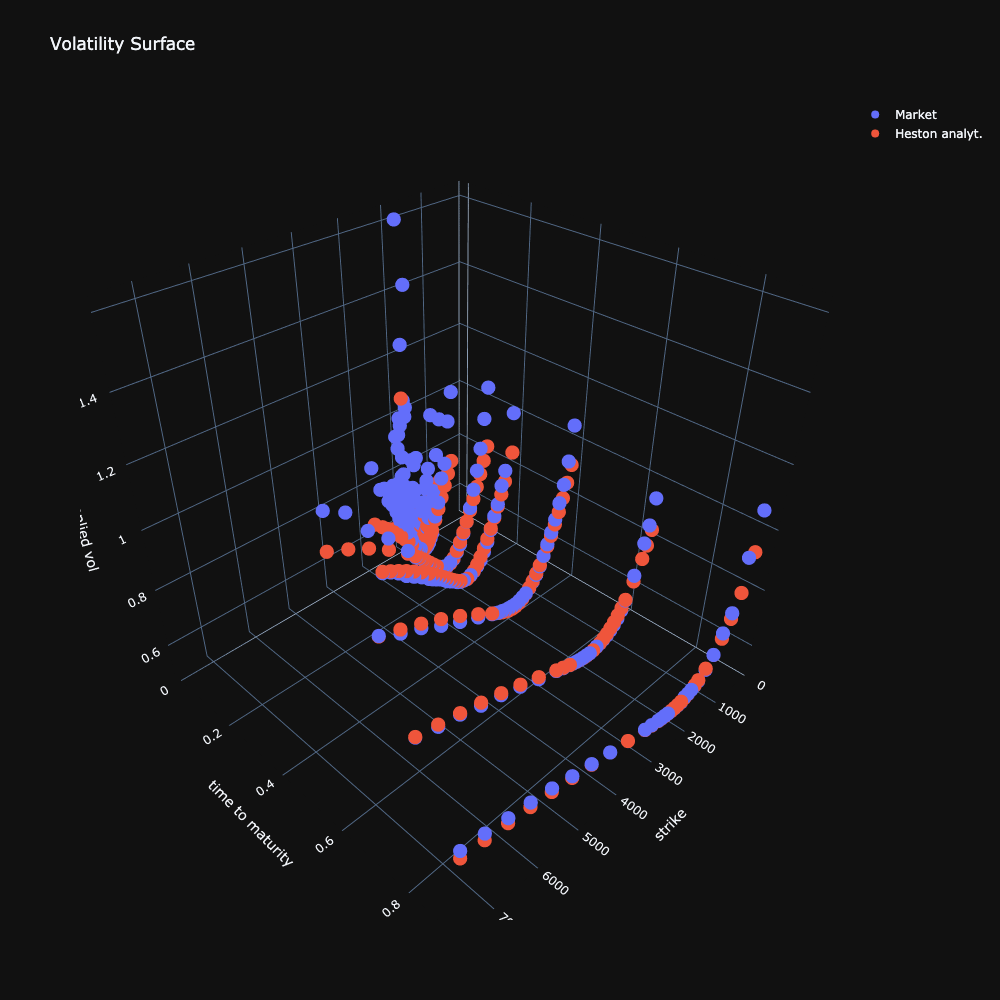

In [12]:
fig = go.Figure(data=[
    go.Scatter3d(z=volsurface_chain.sigmas, x=volsurface_chain.Ks, y=volsurface_chain.Ts, mode='markers', name='Market'),
    go.Scatter3d(z=test_heston_ivs.data, x=volsurface_chain.Ks, y=volsurface_chain.Ts, mode='markers', name='Heston analyt.')
])

fig.update_layout(title='Volatility Surface', template="plotly_dark", width=1000, height=1000)
fig.update_scenes(xaxis_title_text='strike',
                  yaxis_title_text='time to maturity',
                  zaxis_title_text='implied vol')

fig.show(renderer='png')  # use fig.show() without parameters to have interactive plot

The implied volatilities obtained with the calibrated Heston model are close to the market data.

Now let's compute the continuous volatility surface using the calibrated model. We will also show how the volatility surface changes with the change of Heston model parameters.

In [13]:
K_arr = np.linspace(800, 5000, num=100)
T_arr = np.linspace(0.1, 1., num=100)
K_grid, T_grid = np.meshgrid(K_arr, T_arr)
full_grid = StrikesMaturitiesGrid(
    volsurface_chain.forward_curve().spot(),
    TimesToMaturity(T_grid.flatten()),
    Strikes(K_grid.flatten())
)

In [14]:
calibrated_heston_ivs = heston_calc.surface_grid_ivs(heston_params, full_grid).data.reshape(100, 100)

In [15]:
heston_params.v0 *= 2
calibrated_heston_ivs_v0 = heston_calc.surface_grid_ivs(heston_params, full_grid).data.reshape(100, 100)
heston_params.v0 /= 2

In [16]:
heston_params.kappa *= 3
calibrated_heston_ivs_kappa = heston_calc.surface_grid_ivs(heston_params, full_grid).data.reshape(100, 100)
heston_params.kappa /= 3

In [17]:
heston_params.rho *= 2
calibrated_heston_ivs_rho = heston_calc.surface_grid_ivs(heston_params, full_grid).data.reshape(100, 100)
heston_params.rho /= 2

In [18]:
heston_params.theta *= 2
calibrated_heston_ivs_theta = heston_calc.surface_grid_ivs(heston_params, full_grid).data.reshape(100, 100)
heston_params.theta /= 2

In [19]:
heston_params.eps *= 2
calibrated_heston_ivs_eps = heston_calc.surface_grid_ivs(heston_params, full_grid).data.reshape(100, 100)
heston_params.eps /= 2

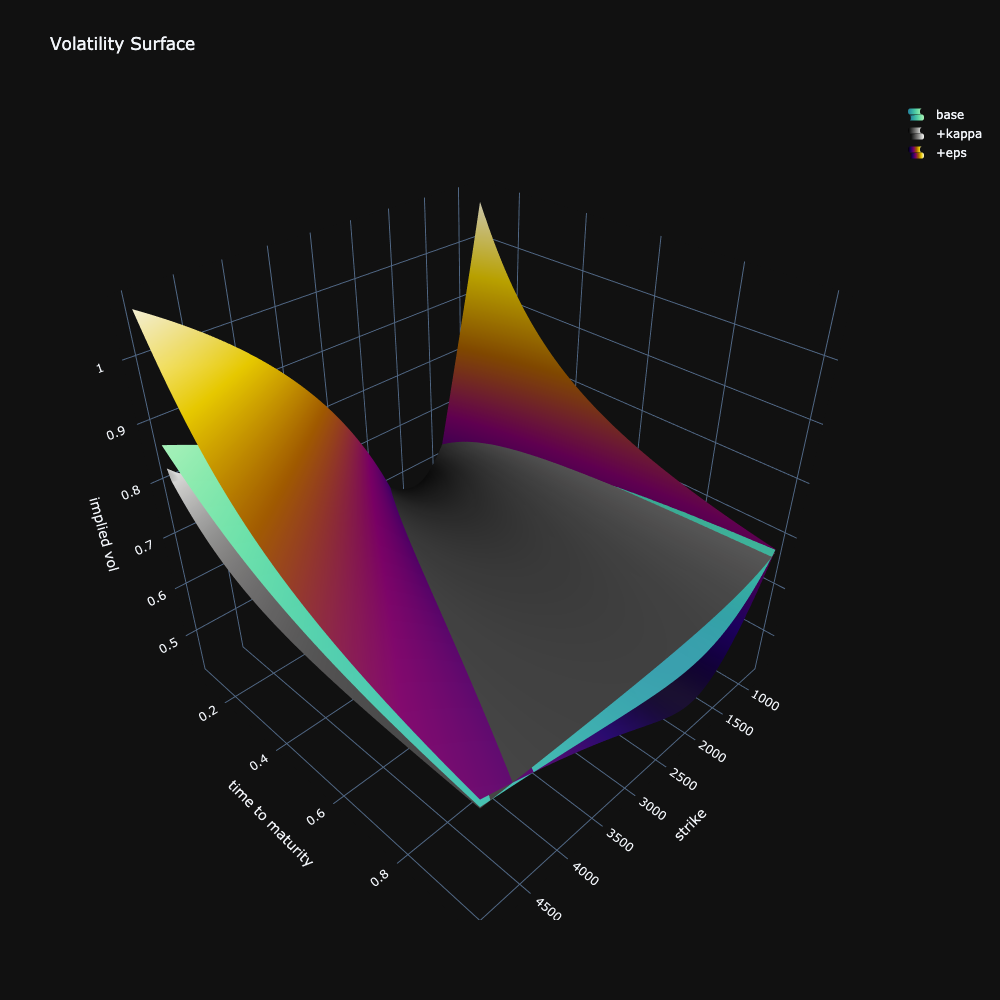

In [20]:
fig = go.Figure(data=[
    go.Surface(z=calibrated_heston_ivs, x=K_grid, y=T_grid, colorscale='Tealgrn_r', name='base'),
    # go.Surface(z=calibrated_heston_ivs_v0, x=K_grid, y=T_grid, colorscale='Delta', name='+v0'),
    go.Surface(z=calibrated_heston_ivs_kappa, x=K_grid, y=T_grid, colorscale='gray', name='+kappa'),
    # go.Surface(z=calibrated_heston_ivs_rho, x=K_grid, y=T_grid, colorscale='spectral', name='-rho'),
    # go.Surface(z=calibrated_heston_ivs_theta, x=K_grid, y=T_grid, colorscale='turbo', name='theta'),
    go.Surface(z=calibrated_heston_ivs_eps, x=K_grid, y=T_grid, colorscale='electric', name='+eps'),
])
fig.update_layout(title='Volatility Surface', template="plotly_dark", width=1000, height=1000)
fig.update_scenes(xaxis_title_text='strike',
                  yaxis_title_text='time to maturity',
                  zaxis_title_text='implied vol')
fig.update_traces(showlegend=True, showscale=False)

fig.show(renderer='png')  # use fig.show() without parameters to have interactive plot

# Heston simulation and Monte-Carlo pricing

By the principle of risk-neutral valuation, the present value of a derivative contract with possibly path-dependent payoff $\mathcal{P}$ is given by discounted expectation of the payoff:

$$
V(S_0, 0) = e^{-rT} \cdot \mathbb{E}_Q[\mathcal{P}\, |\, S_t\ \text{starting from}\ S_0],
$$

where $S_t$ is the price of the underlying asset at time $t$, $V(S_t, t)$ is the value of a contract, $\mathbb{E}_Q$ is the expectation under a risk-neutral measure (see notebook `introduction.ipynb`, section "Risk Neutral Valuation").

The idea of Monte-Carlo pricing is to simulate a big number of paths of the underlying asset and estimate $\mathbb{E}_Q$ as the mean of the payoffs.

We use PyTorch for all mathematical operations in simulation algorithm, so we can in fact apply autograd to the calculated price in order to compute the Greeks for arbitrary derivatives. We will demonstrate this later on in this notebook.

We provide two identical implementations of simulation algorithm in Python and C++. Throughout this notebook we will use the Python implementation. The C++ source code is located in `src/noa/quant/heston_sim.hh` and can be loaded as a PyTorch extension.

In [21]:
N_PATHS = 200_000
DT = 1 / 365
N_STEPS = round(volsurface_chain.Ts[-1] / DT)

S0 = torch.tensor([volsurface_chain.S])
V0 = torch.tensor([heston_params.v0])

In [22]:
init_state_price = S0 * torch.ones(N_PATHS)
init_state_var = V0 * torch.ones(N_PATHS)

heston_paths, var_paths = generate_heston(
    N_PATHS,
    N_STEPS,
    DT,
    init_state_price,
    init_state_var,
    torch.tensor([heston_params.kappa]),
    torch.tensor([heston_params.theta]),
    torch.tensor([heston_params.eps]),
    torch.tensor([heston_params.rho]),
    torch.tensor([heston_params.r]),
)

In [23]:
time_arr = np.linspace(0, N_STEPS * DT, N_STEPS + 1)

In [24]:
def plot_heston_path(i):
    plt.figure(figsize=(11, 6))
    plt.plot(time_arr, heston_paths[i].detach().numpy())
    plt.ylabel('S')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    plt.figure(figsize=(11, 6))
    plt.plot(time_arr, var_paths[i].detach().numpy())
    plt.axhline(heston_params.theta, ls='--', label='θ', lw=1, c='orange')
    plt.ylabel('Variance (CIR process)')
    plt.xlabel('Time')
    plt.legend()
    plt.grid()
    plt.show()

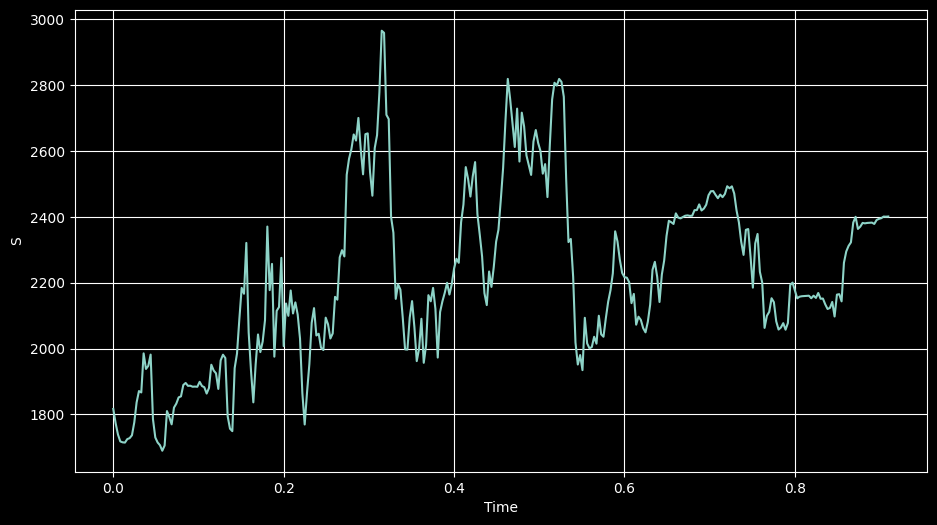

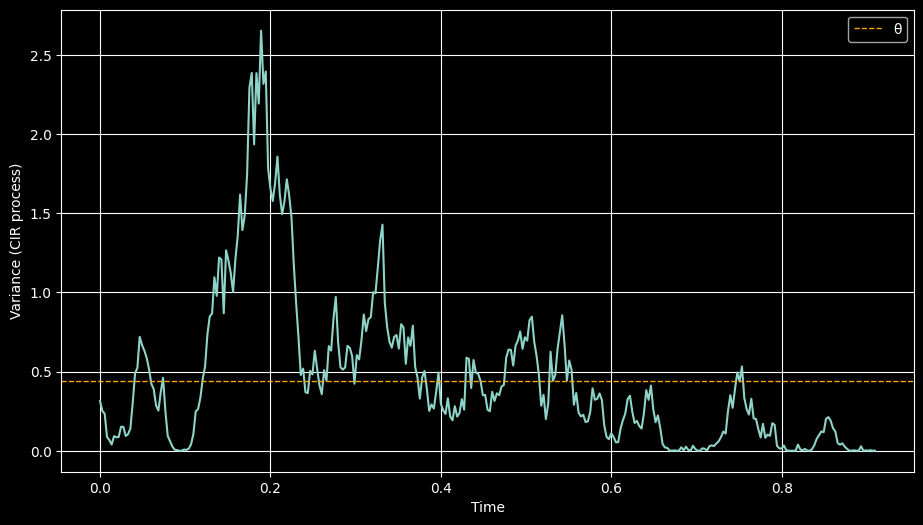

In [25]:
plot_heston_path(3)

## Vanilla Call Option

In [26]:
def call_payoff(S, K):
    return torch.maximum(S - K, torch.zeros_like(S))

def put_payoff(S, K):
    return torch.maximum(K - S, torch.zeros_like(S))

def get_premium(payoffs, r, T):
    return torch.exp(-r * T) * torch.mean(payoffs)

In [27]:
euro_prices_mc = []
Fs = volsurface_chain.S * np.exp(heston_params.r * volsurface_chain.Ts)
is_call = Fs <= volsurface_chain.Ks

for i in range(len(volsurface_chain.Ks)):
    expiry_idx = np.argmin(np.abs(time_arr - volsurface_chain.Ts[i]))
    if is_call[i]:
        payoffs = call_payoff(heston_paths[:, expiry_idx], volsurface_chain.Ks[i])
    else:
        payoffs = put_payoff(heston_paths[:, expiry_idx], volsurface_chain.Ks[i])
        
    price = get_premium(
        payoffs = payoffs,
        r = torch.tensor([heston_params.r]),
        T = DT * expiry_idx
    )
    euro_prices_mc.append(price.item())

In [28]:
def get_ivs(pvs: np.ndarray, grid: StrikesMaturitiesGrid, r: float):
    ivs = np.zeros_like(pvs)
    r = ForwardYield(r)
    S = grid.spot()
    bs_calc = BSCalc()

    for i in range(len(pvs)):
        T = TimeToMaturity(grid.Ts[i])
        F = Forward(S, r, T)
        ivs[i] = bs_calc.implied_vol(F, Strike(grid.Ks[i]), Premium(pvs[i])).sigma

    return ImpliedVols(ivs)

In [29]:
test_heston_ivs_montecarlo = get_ivs(
    np.array(euro_prices_mc),
    volsurface_chain.strikes_maturities_grid()[0],
    heston_params.r
)

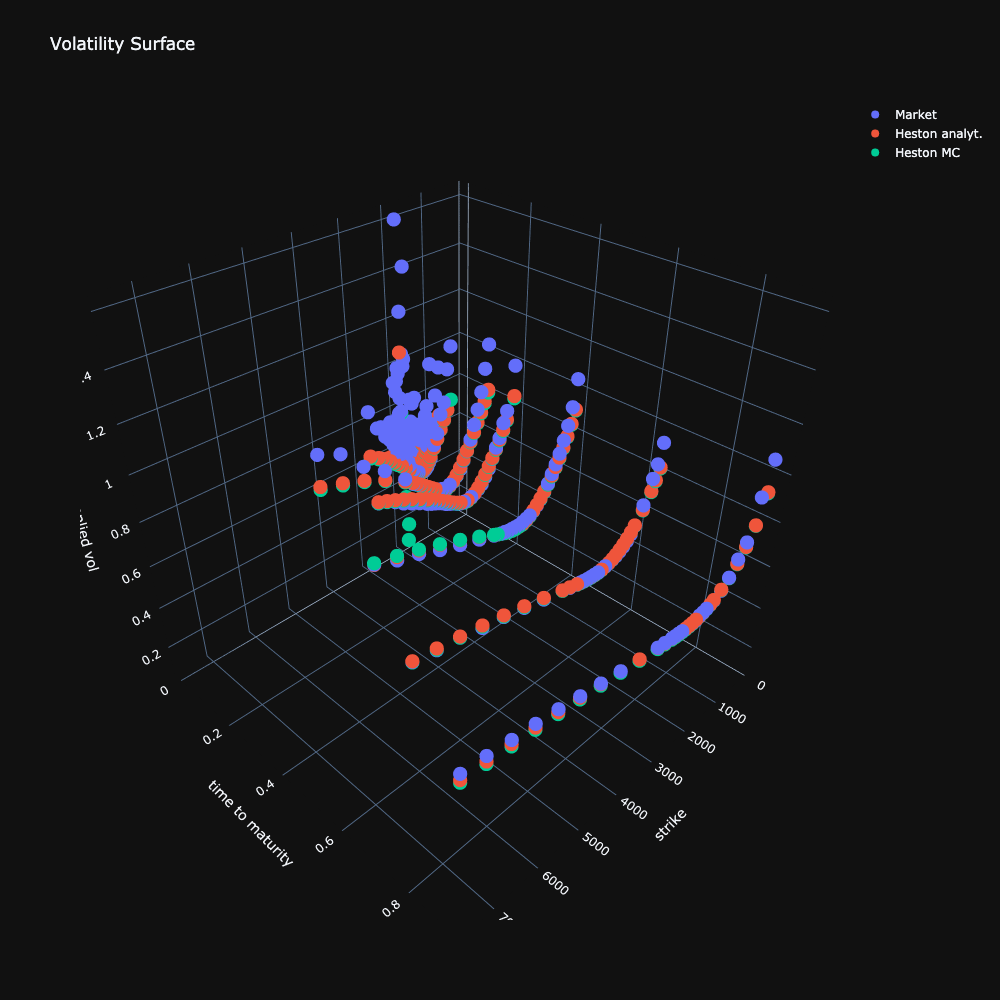

In [30]:
fig = go.Figure(data=[
    go.Scatter3d(z=volsurface_chain.sigmas, x=volsurface_chain.Ks, y=volsurface_chain.Ts,
                 mode='markers', name='Market'),
    go.Scatter3d(z=test_heston_ivs.data, x=volsurface_chain.Ks, y=volsurface_chain.Ts,
                 mode='markers', name='Heston analyt.'),
    go.Scatter3d(z=test_heston_ivs_montecarlo.data, x=volsurface_chain.Ks, y=volsurface_chain.Ts,
                 mode='markers', name='Heston MC')
])

fig.update_layout(title='Volatility Surface', template="plotly_dark", width=1000, height=1000)
fig.update_scenes(xaxis_title_text='strike',
                  yaxis_title_text='time to maturity',
                  zaxis_title_text='implied vol')

fig.show(renderer='png')  # use fig.show() without parameters to have interactive plot

The values obtained by Monte-Carlo method are generally very close to the analytical values. The precision can be further improved by increasing the number of simulated paths.

## Barrier Options

Barrier options have the following payoffs:
$$\text{UpIn Call}_T = \max[S_T - K,\ 0] \cdot 1_{\left\{ \max_{t\in[0, T]}[S(t)]\ \geq\ B \right\}},$$

$$\text{UpIn Put}_T = \max[K - S_T,\ 0] \cdot 1_{\left\{ \max_{t\in[0, T]}[S(t)]\ \geq\ B \right\}},$$

$$\text{UpOut Call}_T = \max[S_T - K,\ 0] \cdot 1_{\left\{ \max_{t\in[0, T]}[S(t)]\ <\ B \right\}},$$

$$\text{UpOut Put}_T = \max[K - S_T,\ 0] \cdot 1_{\left\{ \max_{t\in[0, T]}[S(t)]\ <\ B \right\}},$$

$$\text{DownIn Call}_T = \max[S_T - K,\ 0] \cdot 1_{\left\{ \min_{t\in[0, T]}[S(t)]\ \leq\ B \right\}},$$

$$\text{DownIn Put}_T = \max[K - S_T,\ 0] \cdot 1_{\left\{ \min_{t\in[0, T]}[S(t)]\ \leq\ B \right\}},$$

$$\text{DownOut Call}_T = \max[S_T - K,\ 0] \cdot 1_{\left\{ \min_{t\in[0, T]}[S(t)]\ >\ B \right\}},$$

$$\text{DownOut Put}_T = \max[K - S_T,\ 0] \cdot 1_{\left\{ \min_{t\in[0, T]}[S(t)]\ >\ B \right\}},$$

where $S$ – price of the underlying, $T$ – maturity, $K$ – strike, $B$ – barrier. See [review of barrier options](https://bookdown.org/maxime_debellefroid/MyBook/barrier-options.html).


Now we want to calculate the premiums and Greeks for several example barrier options using Monte-Carlo method and autograd. Here we consider only one expiration date, so we can generate new Heston paths with corresponding time horizon to speed up the computation.

Note that now we need to clamp the value of the variance process to the range `[minimum_var, +∞)` on each step of the simulation, to prevent it from being too close to zero. This is necessary to compute the vega Greek (derivative w.r.t. initial variance) using autograd. We do so by setting `minimum_var` parameter of the `generate_heston()` function. Without such clamping, the result of the computation will be `nan`.

For the computation of vega Greek, the `minimum_var` parameter and time step for simulation are actually interdependent. If we increase the time step, this will speed up the computation, but we may also need to increase the `minimum_var` in order for vega computation to yield a non-`nan` value. The latter will increase the approximation error of computed premiums and Greeks.

In [31]:
# Here strike and barriers are in relative values w.r.t spot
BARRIER_K = 1.07
BARRIER_T = 60 / 365

BARRIER_UP_IN    = 1.30
BARRIER_UP_OUT   = 1.30
BARRIER_DOWN_IN  = 0.95
BARRIER_DOWN_OUT = 0.95

In [32]:
N_PATHS_B = 200_000
DT_B = 0.5 / 365
N_STEPS_B = round(BARRIER_T / DT_B)

S0_B = torch.tensor([volsurface_chain.S], requires_grad=True)
V0_B = torch.tensor([heston_params.v0], requires_grad=True)

init_state_price_B = S0_B * torch.ones(N_PATHS_B)
init_state_var_B = V0_B * torch.ones(N_PATHS_B)

heston_paths_B, _ = generate_heston(
    N_PATHS_B,
    N_STEPS_B,
    DT_B,
    init_state_price_B,
    init_state_var_B,
    torch.tensor([heston_params.kappa]),
    torch.tensor([heston_params.theta]),
    torch.tensor([heston_params.eps]),
    torch.tensor([heston_params.rho]),
    torch.tensor([heston_params.r]),
    minimum_var=0.005
)

In [33]:
names, barriers, prices, deltas, vegas = [], [], [], [], []

names.append('Vanilla Call')
barriers.append(np.nan)
prices.append(get_premium(
    payoffs = call_payoff(heston_paths_B[:, -1], BARRIER_K * volsurface_chain.S),
    r = torch.tensor([heston_params.r]),
    T = BARRIER_T
))

names.append(f'Up-In Call')
barriers.append(BARRIER_UP_IN)
prices.append(price_barrier_option(
    paths        = heston_paths_B,
    strike       = torch.tensor(BARRIER_K * volsurface_chain.S),
    maturity     = torch.tensor(BARRIER_T),
    rate         = torch.tensor(heston_params.r),
    barrier      = torch.tensor(BARRIER_UP_IN * volsurface_chain.S),
    barrier_type = 'up-in',
    call         = True
))

names.append(f'Up-Out Call')
barriers.append(BARRIER_UP_OUT)
prices.append(price_barrier_option(
    paths        = heston_paths_B,
    strike       = torch.tensor(BARRIER_K * volsurface_chain.S),
    maturity     = torch.tensor(BARRIER_T),
    rate         = torch.tensor(heston_params.r),
    barrier      = torch.tensor(BARRIER_UP_OUT * volsurface_chain.S),
    barrier_type = 'up-out',
    call         = True
))

names.append(f'Down-In Call')
barriers.append(BARRIER_DOWN_IN)
prices.append(price_barrier_option(
    paths        = heston_paths_B,
    strike       = torch.tensor(BARRIER_K * volsurface_chain.S),
    maturity     = torch.tensor(BARRIER_T),
    rate         = torch.tensor(heston_params.r),
    barrier      = torch.tensor(BARRIER_DOWN_IN * volsurface_chain.S),
    barrier_type = 'down-in',
    call         = True
))

names.append(f'Down-out Call')
barriers.append(BARRIER_DOWN_OUT)
prices.append(price_barrier_option(
    paths        = heston_paths_B,
    strike       = torch.tensor(BARRIER_K * volsurface_chain.S),
    maturity     = torch.tensor(BARRIER_T),
    rate         = torch.tensor(heston_params.r),
    barrier      = torch.tensor(BARRIER_DOWN_OUT * volsurface_chain.S),
    barrier_type = 'down-out',
    call         = True
))

for i in range(len(prices)):
    _delta, _vega = torch.autograd.grad(prices[i], [S0_B, V0_B], retain_graph=True)
    deltas.append(_delta.item())
    vegas.append(_vega.item())

prices = [x.item() for x in prices]

In [34]:
print(f'κ = {heston_params.kappa:.3f}, θ = {heston_params.theta:.3f}, '
      f'ε = {heston_params.eps:.3f}, ρ = {heston_params.rho:.3f}, rate = {heston_params.r:.3f}')
print(f'Spot = {volsurface_chain.S:.2f}')
print(f'Strike/Spot = {BARRIER_K:.2f}')
print(f'Expiration = {BARRIER_T:.3f}')
print()

pd.DataFrame({
    'Option': names,
    'Barrier/Spot': barriers,
    'Price': prices,
    'Delta': deltas,
    'Vega': vegas
})

κ = 4.269, θ = 0.438, ε = 3.384, ρ = -0.124, rate = 0.021
Spot = 1816.70
Strike/Spot = 1.07
Expiration = 0.164



,Option,Barrier/Spot,Price,Delta,Vega
0,Vanilla Call,NaN,107.205,0.412,160.742
1,Up-In Call,1.30,80.353,0.190,106.170
2,Up-Out Call,1.30,26.851,0.223,54.572
3,Down-In Call,0.95,47.542,0.184,52.478
4,Down-out Call,0.95,59.663,0.228,108.263


We can see that barrier options have lower prices than vanilla option with the same strike and expiration time. That's because they carry an additional risk to expire worthless.

## American options

We can calculate the price of American option using LSM algorithm (see notebook `lsm.ipynb`). Similarly to the previous section, we can apply autograd to calculate delta and vega Greeks.

In [35]:
N_PATHS_A = 200_000
DT_A = 0.5 / 365
T_A = 60 / 365
N_STEPS_A = round(T_A / DT_A)

S0_A = torch.tensor([volsurface_chain.S], requires_grad=True)
V0_A = torch.tensor([heston_params.v0], requires_grad=True)

STRIKE_A = torch.tensor([S0_A.item() * 0.95])

print(f'N_STEPS_A: {N_STEPS_A}')

N_STEPS_A: 120


In [36]:
init_state_price_A = S0_A * torch.ones(N_PATHS_A)
init_state_var_A = V0_A * torch.ones(N_PATHS_A)

with torch.no_grad():
    heston_paths1, _ = generate_heston(
        N_PATHS_A,
        N_STEPS_A,
        DT_A,
        init_state_price_A,
        init_state_var_A,
        torch.tensor([heston_params.kappa]),
        torch.tensor([heston_params.theta]),
        torch.tensor([heston_params.eps]),
        torch.tensor([heston_params.rho]),
        torch.tensor([heston_params.r]),
        minimum_var=0.005
    )

heston_paths2, _ = generate_heston(
    N_PATHS_A,
    N_STEPS_A,
    DT_A,
    init_state_price_A,
    init_state_var_A,
    torch.tensor([heston_params.kappa]),
    torch.tensor([heston_params.theta]),
    torch.tensor([heston_params.eps]),
    torch.tensor([heston_params.rho]),
    torch.tensor([heston_params.r]),
    minimum_var=0.005
)

lsm_res = price_american_put_lsm(
    heston_paths1,
    heston_paths2,
    DT_A,
    STRIKE_A,
    torch.tensor([heston_params.r]),
    reg_poly_degree=3
)

In [37]:
amer_delta, amer_vega = torch.autograd.grad(lsm_res.option_price, [S0_A, V0_A])

In [38]:
print(f'Price of American put: {lsm_res.option_price.item():.3f}')
print(f'Delta Greek: {amer_delta.item():.5f}')
print(f'Vega Greek: {amer_vega.item():.3f}')

Price of American put: 106.584
Delta Greek: -0.36627
Vega Greek: 158.435


# References

* [Andersen2007] [Andersen, L.B., 2007. Efficient simulation of the Heston stochastic volatility model. Available at SSRN 946405.](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=946405)
* [Grzelak2019] Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)
* [Cui2017] [Cui, Y. et al. *Full and fast calibration of the Heston stochastic volatility model.* European Journal of Operational Research 263.2 (2017)](https://www.sciencedirect.com/science/article/pii/S0377221717304460)
* [Online book about derivatives by Maxime de Bellefroid](https://bookdown.org/maxime_debellefroid/MyBook/)